In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'


import torch.utils.tensorboard as tb
import datetime
import os
from tqdm.notebook import tqdm
import time 


# Comparing MLP and Convolutional Models

## Description

In this week's homework, we'll use PyTorch to compare the performance of multi-layer perceptrons (MLP's; the kind of model we've looked at so far) against _convolutional_ neural networks (CNN's). We'll talk about convolutions in class on Monday, but you can get started on the MLP part of the homework as soon as you're ready. For our comparison we'll go back to the CIFAR-10 dataset, since it's a bit less chaotic than CIFAR-100.

As with the last homework, I have some guidelines about what parts of the homework are necessary for different grades:

- The basic version, for a C, is to define and train an MLP and a CNN.
- On top of that, the B level work requires you to analyze your results a bit. I'll describe this in more detail later in the notebook after the code that sets up and trains the networks.
- For an A, you'll need to finish the activation map visualization in the last section of this notebook. More details on that later on.

The rest of the document is organized into sections which are labeled with the grade they correspond to.


`code`


## Data Setup

The first section of the notebook gets the dataset and sets up the transforms we need. The code in this section is complete, although you may need to change the dataset path or change the `transform` definition to match your version of torchvision.

In [48]:
# Directories

model_dir = "models"

logs_dir = "logs"

In [12]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ConvertImageDtype(),
])

# If you already have the CIFAR10 data downloaded from the in-class notebook, you can change the path here
# to point to it so you avoid downloading a second copy.
cifar = torchvision.datasets.CIFAR10("../data/torch/cifar", download=True, transform=transform)
train_size = int(0.8 * len(cifar))
train_data, valid_data = torch.utils.data.random_split(cifar, [train_size, len(cifar) - train_size])

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified


In [13]:
# Constants

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

normalize = transforms.Normalize(cifar_mean, cifar_std)

### Set device to GPU

In [14]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else: 
    device = 'cpu'

print("Device:", device)

Device: mps


## Models and Training (C)

### MLP

In [15]:
class MLP(nn.Module):

    def __init__(self, arch=[256, 128], activation=nn.ReLU):
        super().__init__()
        self.layers = []
        arch.insert(0, 3 * 32 * 32)
        arch.append(100)
        for i in range(len(arch) - 1):
            self.layers.append(nn.Linear(arch[i], arch[i+1]))
            if i < len(arch) - 2:
                self.layers.append(activation())
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x.reshape(-1, 3 * 32 * 32)).squeeze(dim=0)

### CNN

In [35]:
class CNN(nn.Module):

    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.c1 = nn.Conv2d(3, 8, 3, padding=3)
        self.a1 = activation()
        self.c2 = nn.Conv2d(8, 16, 3, groups=2, padding=1, stride=2)
        self.a2 = activation()
        self.c3 = nn.Conv2d(16, 32, 3, stride=2)
        self.flatten = nn.Flatten()
        self.l1 =  nn.Linear(32*8*8, 10)

    def forward(self, x):
        h1 = self.c1(x)
        h2 = self.a1(h1)
        h3 = self.c2(h2)
        h4 = self.a2(h3)
        h5 = self.c3(h4)
        h6 = self.flatten(h5)
        h7 = self.l1(h6)
        return h7

### Train function

Now let's define a training function for our MLP. As usual, you may want to add more arguments to the training function. For the latter parts of the notebook, it will be helpful if your training function returns both the model and a list of the training and validation accuracies for each epoch.

In [36]:
def train(model_class=MLP, arch= [256,128], lr=1e-3, epochs=10, batch_size=64, momentum=0.9, reg=1e-5, activation=nn.ReLU, use_augmentation=False, aug_params=None):
    start = time.time()
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False) # why shuffle = false here?

    if use_augmentation:
        augments = transforms.Compose([
            transforms.RandomHorizontalFlip(aug_params['flip_prob']),
            transforms.RandomGrayscale(aug_params['grayscale_prob']),
            transforms.ColorJitter(
                brightness=(aug_params['bright_min'], aug_params['bright_max']),
                contrast=0,
                saturation=0,
                hue=0),
            transforms.RandomCrop(
                size=32,
                padding=aug_params['shift_size'],
                fill=cifar_mean)
        ])

# total num parameters
        # linear = xW+b, whre w is a matrix and b is bias vector, so total number params is just entries in matrix and bias vector
        # 
    train_accs = []
    valid_accs = []

    if model_class == MLP:
        model = MLP(arch=arch, activation=activation).to(device)
    if model_class == CNN:
        model = CNN().to(device)

    loss = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), momentum=momentum, lr=lr, weight_decay=reg)


    # Name each training run
    name = ":".join(map(str, arch))
    name += '-lr-' + str(lr) + '-bs-' + str(batch_size) + '-mom-' + str(momentum) + '-epochs-' + str(epochs) + '-reg-' + str(reg)
    logger = tb.SummaryWriter(os.path.join(logs_dir, name))
    global_step = 0
    
    for i in tqdm(range(epochs)):
        model.train()
        # accs = []
        for batch_xs, batch_ys in data_loader:
            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)

            if use_augmentation:
                batch_xs = augments(batch_xs).to(device)

            preds = model(normalize(batch_xs))
            loss_val = loss(preds, batch_ys)
            # accs.append((preds.argmax(dim=1) == batch_ys).float().mean())

            logger.add_scalar("Loss", loss_val, global_step=glob)

            # Update
            opt.zero_grad()
            loss_val.backward()
            opt.step()

            logger.add_scalar("Training accuracy", (preds.argmax(dim=1) == batch_ys).float().mean(), global_step=global_step)

            global_step += 1

       
        # average training accuracy
        # train_accs.append(torch.tensor(accs).mean().item())

        # start over for eval stage
        model.eval()
        valid_accs = []
        for batch_xs, batch_ys in valid_loader:
            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)
            valid_preds = model(normalize(batch_xs))
            valid_accs.append((valid_preds.argmax(dim=1) == batch_ys).float().mean())
        
        # logger.add_scalar("Validation accuracy", torch.tensor(valid_accs).mean().item(), global_step=global_step)
        logger.add_scalar("Validation accuracy", torch.tensor(valid_accs).mean(), global_step=global_step)

        
        
        print("Epoch:", i, "Training accuracy:",train_accs[-1], "Validation accuracy:", valid_accs[-1])
    train_time = time.time() - start
    logger.add_scalar("Training time", train_time, global_step=global_step )
    return model, train_accs, valid_accs

### Train MLP

In [18]:
# %%time

aug_params = {
    'flip_prob': 0.5,
    'grayscale_prob': 0.1,
    'bright_min': 0.9,
    'bright_max': 1.1,
    'shift_size': 2
}

mlp_model, mlp_train_accs, mlp_valid_accs = train(model_class=MLP, 
                                                    arch= [256,128],
                                                    lr=1e-3, 
                                                    epochs=2, 
                                                    batch_size=64,
                                                    momentum=0.9,
                                                    reg=1e-5, 
                                                    activation=nn.ReLU, 
                                                    use_augmentation=True, 
                                                    aug_params=aug_params
                                                    )


Epoch: 0 Training accuracy: 0.27012500166893005 Validation accuracy: 0.36823248863220215
Epoch: 1 Training accuracy: 0.35542500019073486 Validation accuracy: 0.40694665908813477
CPU times: user 13.7 s, sys: 1.31 s, total: 15 s
Wall time: 16.9 s


### Train CNN

In [37]:
%%time
cnn_model, cnn_train_accs, cnn_valid_accs = train(model_class=CNN, 
                                                    lr=1e-2, 
                                                    epochs=2, 
                                                    batch_size=64,
                                                    momentum=0.9,
                                                    reg=1e-5, 
                                                    activation=nn.ReLU, 
                                                    use_augmentation=True, 
                                                    aug_params=aug_params)

Epoch: 0 Training accuracy: 0.3673500120639801 Validation accuracy: 0.49203822016716003
Epoch: 1 Training accuracy: 0.48122501373291016 Validation accuracy: 0.5408041477203369
CPU times: user 15.5 s, sys: 1.28 s, total: 16.8 s
Wall time: 18.8 s


#### Visualize CNN predictions

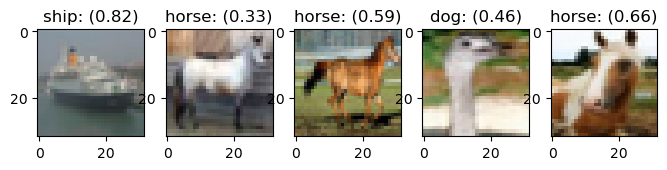

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(8, 8))
for i in range(5):

    # Get a random image from CIFAR
    r = torch.randint(len(cifar), (1,)).item()

    # put the image on the gpu


    cifar_gpu = ((cifar[r][0]).unsqueeze(0)).to(device)

    preds = nn.functional.softmax(cnn_model(normalize(cifar_gpu)), dim=1)
    preds = preds.cpu()

    c = torch.argmax(preds)
    axs[i].imshow(cifar[r][0].numpy().transpose(1, 2, 0))
    axs[i].set_title("{}: ({:.2f})".format(classes[c], preds[0,c].item()))
    # axs[i].set_title(classes[cifar[r][1]])
plt.show()



In [ ]:
# Plot the training error against the validation error 

smooth_train = np.convolve(mlp_train_accs, np.ones(2) / 2, mode='valid')
smooth_valid = np.convolve(mlp_valid_accs, np.ones(2) / 2, mode='valid')
plt.plot(range(len(smooth_train)), 1-smooth_train, label='training error')
plt.plot(range(len(smooth_valid)), 1-smooth_valid, label='validation error')
plt.yscale('log')
plt.legend()
plt.show()

#### Save models

In [49]:
torch.save(cnn_model.state_dict(), os.path.join(model_dir, 'cnn_model.pt'))

torch.save(mlp_model.state_dict(), os.path.join(model_dir, 'mlp_model.pt'))

In [ ]:
# Load

loaded_cnn = CNN()
loaded_cnn.load_stat_dict(torch.load("cnn_model.pt"))

loaded_mlp = CNN()
loaded_mlp.load_stat_dict(torch.load("mlp_model.pt"))

## Analysis (B)

In this section, we'll do some minor analysis of the results of our experiment above. Let's compare

- the time taken to train each model,
- the validation accuracy over time,
- the total number of parameters in each model.

That last measurement, the total number of parameters, is something you'll need to compute pased on your network architecture. When I say number of parameters here, I'm referring to the total number of dimensions in the parameter space. That is, the total number of individual real numbers in our parameters. For example, a matrix of size 100x10 has 1,000 parameters.

I'm not asking for anything specific here, I'm just looking for you to think about the models we're using and their relative merits. If you think of something else that might be useful to compare the two networks, mention that as well.

## Interpretation (A)

In this section, we'll explore our CNN and try to understand how it learns to recognize different objects. There are several approaches to this problem. For today we'll look at a simple one that only works for the first convolutional layer. If we plot the weights of the layer as image data, we can visualize the kinds of patterns the convolution is scanning for. In order to do this, you'll need to normalize each kernel to the range [0, 1], then transpose the axis to format the weights as image data, then use the `imshow` function from `matplotlib.pyplot`. The weights of a convolutional layer `conv` are stored as a tensor of shape `Cin, Cout, H, W` in `conv.weight`.

If you have a torch tensor `x` and you want to display it with `imshow` you'll need to convert it to numpy by calling `x.detach().numpy()`.

In [ ]:
# If your first convolutional layer has fewer than 16 output channels then you'll need to
# change the number of plots here.
fig, axs = plt.subplots(4, 4, figsize=(5, 5))
for i in range(4):
    for j in range(4):
        c = 4 * i + j
        YOUR_CODE_HERE
        axs[i,j].imshow(YOUR_CODE_HERE)
plt.show()